# Deep Q-Network implementation (PyTorch).

In this notebook, we will implement DQN with **experience replay** and **target networks**.

<!-- $$ 
\DeclareMathOperator*{\max}{max}$$ -->

Q Learning control is carried out by sampling step by step and updating Q values at each step. We use ε-greedy policy to explore and generate samples. However, the policy learnt is a deterministic greedy policy with no exploration. We can carryout updates online i.e. we take a step and use `(current state, action, reward and next_state)` tuple to update. 

In case of function approximation using neural network, the input to the network is the state and output is the q(s,a) for all the actions in the state `s`. It is denoted as $ \hat{q}(s_t,a; w_{t}) $, where $w_{t}$ is the weigths of the neural network which we are trying to learn as part of DQN learning. 

We use two networks, one target network to get the max q-value of next state denoted by $ \max_a \hat {q}(s_{t+1},a; w^{-}_{t}) $ and the primary network with weights $w_{t}$ which we are updated based on back propagation of the TD error through the network.

The Update equation is given below. This is the online version:
$$ w_{t+1} \leftarrow w_t + \alpha [ R_{t+1} + \gamma . \max_{a} \hat{q}(S_{t+1},a,w^{-}_{t}) – \hat{q}(S_t,A_t,w_t)] \nabla \hat{q}(S_t,A_t,w_t)$$

Online update with neural network with millions of weights does not work well. Accordingly, We use experience replay (aka Replay Buffer).  We use a behavior policy to explore the environment and store the samples `(s, a, r, s', done)` in a buffer. The samples are generated using an exploratory behavior policy while we improve a deterministic target policy using q-values. 

Therefore, we can always use older samples from behavior policy and apply them again and again. We can keep the buffer size fixed to some pre-determined size and keep deleting the older samples as we collect new ones. This process makes learning sample efficient by reusing a sample multiple times and also removing temporal dependence of the samples we would otherwise see while following a trajectory.

The update equation with batch update with minor modifications is given below. We collect samples of transitions (current state, action, reward, next state) in a buffer. Where each sample is denoted as a tuple: 

$$ (s_{i}, a_{i}, r_{i}, s^{'}_{i}, done_{i})$$

Subscript (i) denotes ith sample. We take N samples from experience replay selecting randomly and update the weights. Subscript (t) denotes the index of weight updates. If the current state is done, as denoted by `done` flag, the target is just the reward as terminal states have zero value. The final update equation is as given below:

$$w_{t+1} \leftarrow w_t + \alpha \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import gym
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.signal import convolve, gaussian

import os
import io
import base64
import time
import glob
from IPython.display import HTML

%matplotlib inline


d:\Anacoda\anacoda\envs\test02\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Environment - My Sensor Network 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and then try to run this on many other environments like Atari games and others.


In [62]:
a = np.array([1,0,100,100,100,100])
a[1:].any() == 0

False

In [105]:
class NodeworldEnv():
    def __init__(self, g=1, alpha1=0.5, alpha2=0.05):
        # 创建一个空的无向图
        self.G = nx.Graph()

        # 添加节点
        # self.G.add_node(1, pos=(-1,0.5), weight=80)
        # self.G.add_node(2, pos=(0,1), weight=50)
        # self.G.add_node(3, pos=(0,0), weight=90)
        # self.G.add_node(4, pos=(1,1), weight=70)
        # self.G.add_node(5, pos=(1,0), weight=80)

        self.G.add_node(1, pos=(-1,0.5), weight=100)
        self.G.add_node(2, pos=(0,1), weight=100)
        self.G.add_node(3, pos=(0,0), weight=100)
        self.G.add_node(4, pos=(1,1), weight=100)
        self.G.add_node(5, pos=(1,0), weight=100)

        # 添加边并设置权重
        self.G.add_edge(1, 2, weight=10)  # 边的权重为1
        self.G.add_edge(1, 3, weight=10)
        self.G.add_edge(2, 3, weight=10)
        self.G.add_edge(2, 4, weight=10)  
        self.G.add_edge(3, 5, weight=10)  
        self.G.add_edge(4, 5, weight=10)  

        # 状态空间
        self.observation_space = np.array([1,100,100,100,100,100]) # 状态空间
        # self.__terminal_space = dict()          # terminal state dict
        # self.__terminal_space[4] = 1

        # 动作空间
        self.action_space = np.array([1,2,3,4,5])


        # 定义环境的状态空间和动作空间大小
        self.nS = self.G.number_of_nodes()  # 状态空间大小为节点数量
        # self.nA = self.G.number_of_edges()  # 动作空间大小为边的数量
        self.nA = self.G.number_of_nodes()

        self.reward_range = [-1000,0]
        self.metadata = None

        # 记录当前状态和起始状态
        self.current_state = None
        self.start_state = 1
        
        self.__gamma = 0.5
        self.__g = g
        self.__alpha1 = alpha1
        self.__alpha2 = alpha2

    def isterminal(self, state):
        if state[0] == 4:
            return True
        if not state[1:].all() > 0:
            return True
        return False

    def get_weight(self, state):
        return self.G.nodes[state]['weight']

    def get_neighbors_average_weight(self, state):
        neighbors = list(self.G.neighbors(state))
        all_weights = 0.0
        for node in neighbors:
            all_weights += self.get_weight(node)

        return all_weights/len(neighbors)
    
    def _reward(self, state, next_state):

        state = state[0]

        r = 0.0
        if next_state.all() == None:
            r = -self.__g - self.__alpha1*(1-self.get_weight(state)/100)
            +self.__alpha2*(self.get_weight(state)-self.get_neighbors_average_weight(state))
        else:
            next_state = next_state[0]
            r = -self.__g - self.__alpha1*(1-self.get_weight(state)/100+1-self.get_weight(next_state)/100)
            +self.__alpha2*np.pi/2*(np.arctan(self.get_weight(state)-self.get_neighbors_average_weight(state))
                                    +np.arctan(self.get_weight(next_state)-self.get_neighbors_average_weight(next_state)))

        return r

    def reset(self):
        # # 随机选择起始节点作为重置环境操作
        # self.start_state = random.choice(list(self.G.nodes()))
        # self.current_state = self.start_state
        self.start_state = np.array([1, 100, 100, 100, 100, 100])
        self.current_state = self.start_state
        return self.current_state
    
    def transform(self, state, action):
        # 卫语句
        # if state in self.__terminal_space:
        #     return state, self._reward(state, None), True, {}
        if self.isterminal(state):
            return state, self._reward(state, None), True, {}

        # 状态转移
        neighbors = list(self.G.neighbors(state[0]))
        if action not in neighbors:
            next_state = state
        else:
            next_state = np.array([action,self.get_weight(1),self.get_weight(2),self.get_weight(3),self.get_weight(4),self.get_weight(5)])

        # 计算回报
        r = self._reward(state, next_state)

        # 判断是否终止
        is_terminal = False
        # if next_state in self.__terminal_space:
        #     is_terminal = True
        if self.isterminal(next_state):
            is_terminal = True

        return next_state, r, is_terminal, {}

    def step(self, action):
        """
        :param action:
        :return: next_state, reward, is_terminal, 调试信息
        """
        state = self.current_state
        next_state, r, is_terminal, _ = self.transform(state, action)

        self.current_state = next_state

        return next_state, r, is_terminal, {}

    def render(self):
        # 绘制节点图
        # pos = nx.spring_layout(self.G)
        plt.clf()
        pos = nx.get_node_attributes(self.G, 'pos')
        edge_labels = nx.get_edge_attributes(self.G, 'weight')
        node_weights = nx.get_node_attributes(self.G, 'weight')
        colors = ['gray','gray','gray','gray','gray']
        colors[self.current_state[0]-1] = 'red'
        plt.figure(1)
        nx.draw(self.G, pos, with_labels=True,node_color=colors,node_size=1500)
        nx.draw_networkx_edge_labels(self.G, pos, edge_labels=edge_labels)

        # Draw node weights next to the nodes
        for node, (x, y) in pos.items():
            plt.text(x, y + 0.05, f"Weight: {node_weights[node]}", ha='center', fontsize=20)

        # plt.show()
        plt.pause(0.01)

In [94]:
def make_env(seed=None):
    # remove time limit wrapper from environment
    env = NodeworldEnv()
    # if seed is not None:
    #     env.seed(seed)
    return env

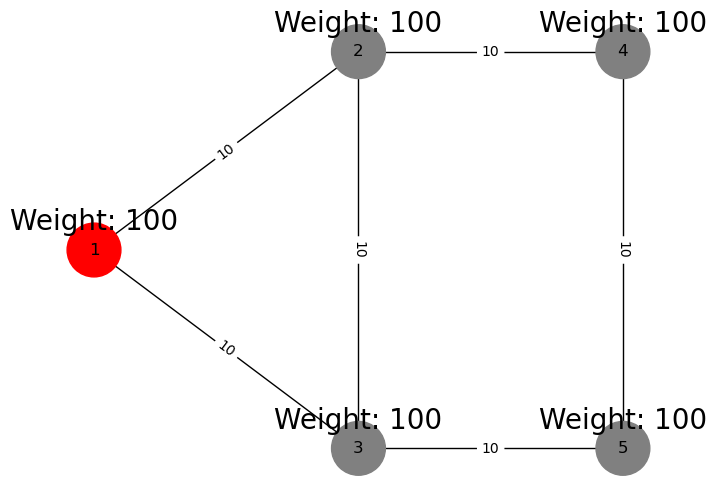

6
5


In [95]:
env = make_env()
env.reset()
env.render()
state_shape, n_actions = 6, 5
print(state_shape)
print(n_actions)

### Building a network using pytorch

Let us build a DQN agent using a simple network. We now need to build a neural network that can map states/observations to state q-values. The observation space and action space is as given below for My Sensor Network

    Observation:
        Type: Box(6)
        Num     Observation
        0       data package position
        1       node1 residual energy
        2       node2 residual energy
        3       node3 residual energy
        4       node4 residual energy
        5       node5 residual energy
    Actions:
        Type: Discrete(5)
        Num     Action
        0       node1
        1       node2
        2       node3
        3       node4
        4       node5
        

The model will be a simple one with 2 hidden layers with Relu activation and final layer being logits with dimension equal to number of actions. 

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [44]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape
        
        state_dim = state_shape
        # a simple NN with state_dim as input vector (input is state s)
        # and self.n_actions as output vector of logits of q(s, a)
        self.network = nn.Sequential()
        self.network.add_module('layer1', nn.Linear(state_dim, 192))
        self.network.add_module('relu1', nn.ReLU())
        self.network.add_module('layer2', nn.Linear(192, 256))
        self.network.add_module('relu2', nn.ReLU())
        self.network.add_module('layer3', nn.Linear(256, 64))
        self.network.add_module('relu3', nn.ReLU())
        self.network.add_module('layer4', nn.Linear(64, n_actions))
        # 
        self.parameters = self.network.parameters
        
    def forward(self, state_t):
        # pass the state at time t through the newrok to get Q(s,a)
        qvalues = self.network(state_t)
        return qvalues

    def get_qvalues(self, states):
        # input is an array of states in numpy and outout is Qvals as numpy array
        states = torch.tensor(states, device=device, dtype=torch.float32)
        qvalues = self.forward(states)
        return qvalues.data.cpu().numpy()

    def sample_actions(self, qvalues):
        # sample actions from a batch of q_values using epsilon greedy policy
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice(
            [0, 1], batch_size, p=[1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [52]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [46]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    rewards = []
    for _ in range(n_games):
        s = env.reset()
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
            reward += r
            if done:
                break

        rewards.append(reward)
    return np.mean(rewards)

In [75]:
print(evaluate(env, agent, n_games=10))
# env.close()

-13.3


### Experience replay

We will use the replay buffer we saw in chapter 4 listings. Replay buffer is very important in DQN to break the correlation between samples. We use a behavior policy ($\epsilon-greedy$) to sample from the environment and store the transitions (s,a,r,s',done) into a buffer. These samples are used multiple times in a learning making the process sample efficient. 

The interface to ReplayBuffer is:
* `exp_replay.add(state, action, reward, next_state, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns states, actions, rewards, next_states and done_flags for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.

We have modified the implementation a bit to make it more efficient

In [76]:
class ReplayBuffer:
    def __init__(self, size):
        self.size = size # max number of items in buffer
        self.buffer =[] # array to holde buffer
        self.next_id = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def add(self, state, action, reward, next_state, done):
        item = (state, action, reward, next_state, done)
        if len(self.buffer) < self.size:
            self.buffer.append(item)
        else:
            self.buffer[self.next_id] = item
        self.next_id = (self.next_id + 1) % self.size
        
    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size)
        samples = [self.buffer[i] for i in idxs]
        states, actions, rewards, next_states, done_flags = list(zip(*samples))
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(done_flags)

In [77]:
def play_and_record(start_state, agent, env, exp_replay, n_steps=1):

    s = start_state
    sum_rewards = 0

    # Play the game for n_steps and record transitions in buffer
    for _ in range(n_steps):
        qvalues = agent.get_qvalues([s])
        a = agent.sample_actions(qvalues)[0]        
        next_s, r, done, _ = env.step(a)
        sum_rewards += r
        exp_replay.add(s, a, r, next_s, done)
        if done:
            s = env.reset()
        else:
            s = next_s
        
    return sum_rewards, s

### Target network


In [78]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

### Learning with... Q-learning
Here we write a function similar to tabular q-learning. We will calculate average TD error per batch using the equation: 

$$ L =  \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right]^2$$


$$ \nabla_w L =   - \frac{1}{N} \sum_{i=1}^{N} \left[ r_i + \left( (1-done_i) . \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t}) \right) – \hat{q}(s_i,a_i;w_t) \right] \nabla \hat{q}(s_i,a_i;w_t)$$


$\hat{q}(s',A;w^{-})$ is calculated using **target network whose weights are held constant and refreshed periodically from the agent learning network**. 

Target is given by following:
* non terminal state: $r_i +  \gamma .  \max_{a^{'}} \hat{q}(s_{i}^{'},a^{'};w^{-}_{t})$
* terminal state: $ r_i $

We then carryout back propagation through the agent network to update the weights using equation below:


$$ 
w_{t+1} \leftarrow w_t - \alpha \nabla_{w}L$$

In [79]:
def compute_td_loss(agent, target_network, states, actions, rewards, next_states, done_flags,
                    gamma=0.99, device=device):

    # convert numpy array to torch tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    done_flags = torch.tensor(done_flags.astype('float32'),device=device,dtype=torch.float)

    # get q-values for all actions in current states
    # use agent network
    predicted_qvalues = agent(states)

    # compute q-values for all actions in next states
    # use target network
    predicted_next_qvalues = target_network(next_states)
    
    # select q-values for chosen actions
    predicted_qvalues_for_actions = predicted_qvalues[range(
        len(actions)), actions]

    # compute Qmax(next_states, actions) using predicted next q-values
    next_state_values, _ = torch.max(predicted_next_qvalues, dim=1)

    # compute "target q-values" 
    target_qvalues_for_actions = rewards + gamma * next_state_values * (1-done_flags)

    # mean squared error loss to minimize
    loss = torch.mean((predicted_qvalues_for_actions -
                       target_qvalues_for_actions.detach()) ** 2)

    return loss

### Main loop

We now carryout the training on DQN setup above.

In [80]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [81]:
# set a seed
seed = 13
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [83]:
#setup env and agent and target networks
# env_name = 'CartPole-v1'
# env = make_env(env_name, seed)
# state_dim = env.observation_space.shape
# n_actions = env.action_space.n
# state = env.reset()

env = NodeworldEnv()
state_dim = 6
n_actions = 5
state = env.reset()

agent = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_dim, n_actions, epsilon=1).to(device)
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

In [84]:
# let us fill experience replay with some samples using full random policy
exp_replay = ReplayBuffer(10**4)
for i in range(100):
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [85]:
#setup some parameters for training
timesteps_per_epoch = 1
batch_size = 32
total_steps = 5 * 10**4

#init Optimizer
opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

# set exploration epsilon 
start_epsilon = 1
end_epsilon = 0.05
eps_decay_final_step = 2 * 10**4

# setup spme frequency for loggind and updating target network
loss_freq = 20
refresh_target_network_freq = 100
eval_freq = 1000

# to clip the gradients
max_grad_norm = 5000

In [86]:
mean_rw_history = []
td_loss_history = []


In [87]:
def epsilon_schedule(start_eps, end_eps, step, final_step):
    return start_eps + (end_eps-start_eps)*min(step, final_step)/final_step

def smoothen(values):
    kernel = gaussian(100, std=100)
    kernel = kernel / np.sum(kernel)
    return convolve(values, kernel, 'valid')

buffer size = 10000, epsilon = 0.05000


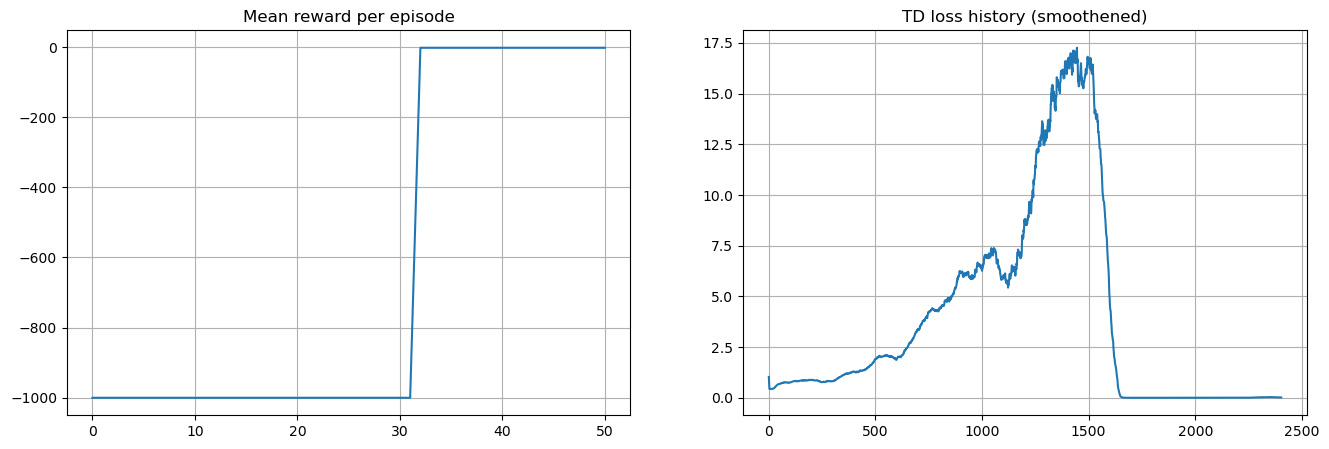

100%|██████████| 50001/50001 [08:10<00:00, 101.84it/s]


In [96]:
state = env.reset()

for step in trange(total_steps + 1):
    
    # reduce exploration as we progress
    agent.epsilon = epsilon_schedule(start_epsilon, end_epsilon, step, eps_decay_final_step)

    # take timesteps_per_epoch and update experience replay buffer
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train by sampling batch_size of data from experience replay
    states, actions, rewards, next_states, done_flags = exp_replay.sample(batch_size)
    

    # loss = <compute TD loss>
    loss = compute_td_loss(agent, target_network, 
                            states, actions, rewards, next_states, done_flags,                  
                            gamma=0.99,
                            device=device)

    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()
    opt.zero_grad()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        # eval the agent
        mean_rw_history.append(evaluate(
            make_env(seed=step), agent, n_games=3, greedy=True, t_max=1000)
        )

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
                (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 5])
        plt.subplot(1, 2, 1)
        plt.title("Mean reward per episode")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(1, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(smoothen(td_loss_history))
        plt.grid()

        plt.show()

In [97]:
final_score = evaluate(
  make_env(),
  agent, n_games=30, greedy=True, t_max=1000
)
print('final score:', final_score)
print('Well done')

final score: -2.0
Well done


**Let us record a video of trained agent**

In [107]:
def generate_animation(env, agent, save_dir):
    
    # try:
    #     env = gym.wrappers.Monitor(
    #         env, save_dir, video_callable=lambda id: True, force=True, mode='evaluation')
    # except gym.error.Error as e:
    #     print(e)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        
    state = env.reset()
    reward = 0
    while True:
        qvalues = agent.get_qvalues([state])
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        if done:
            print('Got reward: {}'.format(reward))
            break
            
def display_animation(filepath):
    video = io.open(filepath, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii')))

In [109]:
# Animate learned policy
save_dir='./videos/pytorch/6_1/'
env = make_env()
generate_animation(env, agent, save_dir=save_dir)
[filepath] = glob.glob(os.path.join(save_dir, '*.mp4'))
display_animation(filepath)


Got reward: -2.0


ValueError: not enough values to unpack (expected 1, got 0)

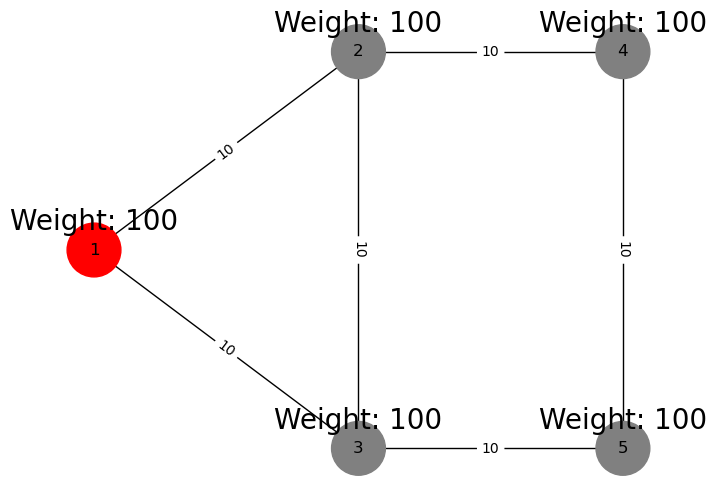

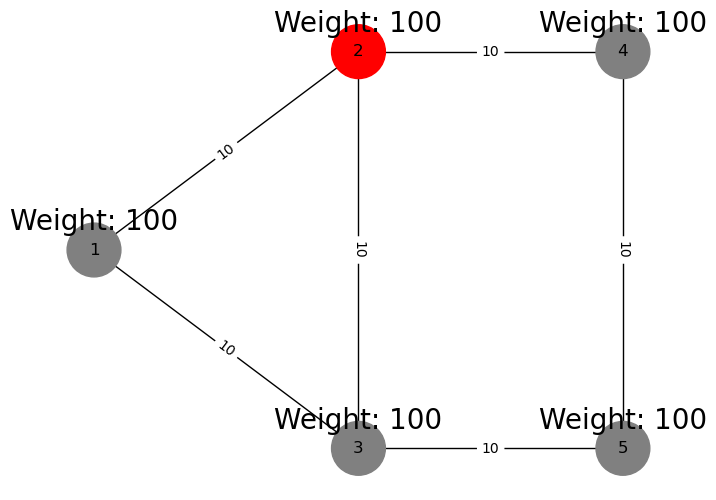

Got reward: -2.0


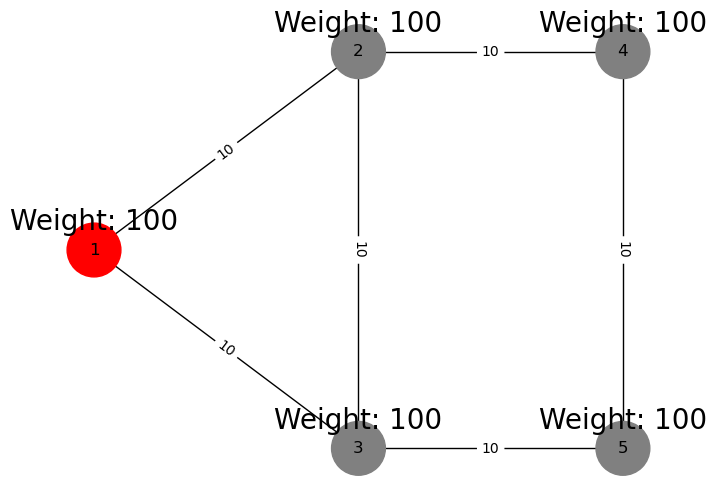

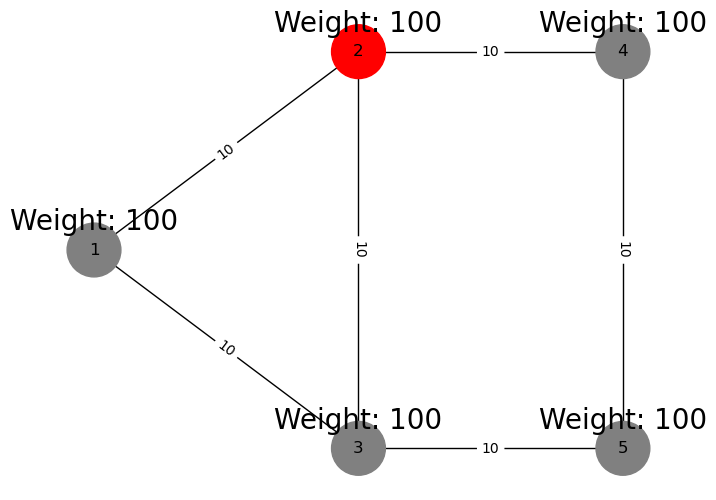

Got reward: -2.0


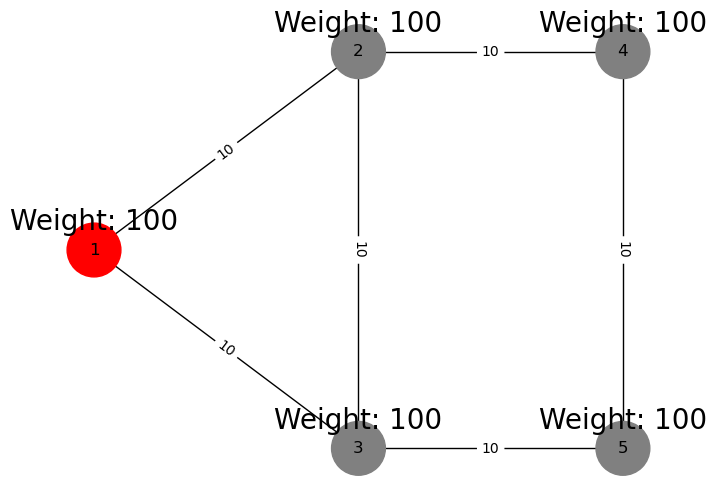

Exception ignored in: <function Monitor.__del__ at 0x000002094FA9C7B8>
Traceback (most recent call last):
  File "d:\Anacoda\anacoda\envs\test02\lib\site-packages\gym\wrappers\monitor.py", line 287, in __del__
    self.close()
  File "d:\Anacoda\anacoda\envs\test02\lib\site-packages\gym\wrappers\monitor.py", line 176, in close
    super(Monitor, self).close()
  File "d:\Anacoda\anacoda\envs\test02\lib\site-packages\gym\core.py", line 312, in close
    return self.env.close()
AttributeError: 'NodeworldEnv' object has no attribute 'close'
Exception ignored in: <function Monitor.__del__ at 0x000002094FA9C7B8>
Traceback (most recent call last):
  File "d:\Anacoda\anacoda\envs\test02\lib\site-packages\gym\wrappers\monitor.py", line 287, in __del__
    self.close()
  File "d:\Anacoda\anacoda\envs\test02\lib\site-packages\gym\wrappers\monitor.py", line 176, in close
    super(Monitor, self).close()
  File "d:\Anacoda\anacoda\envs\test02\lib\site-packages\gym\core.py", line 312, in close
    r

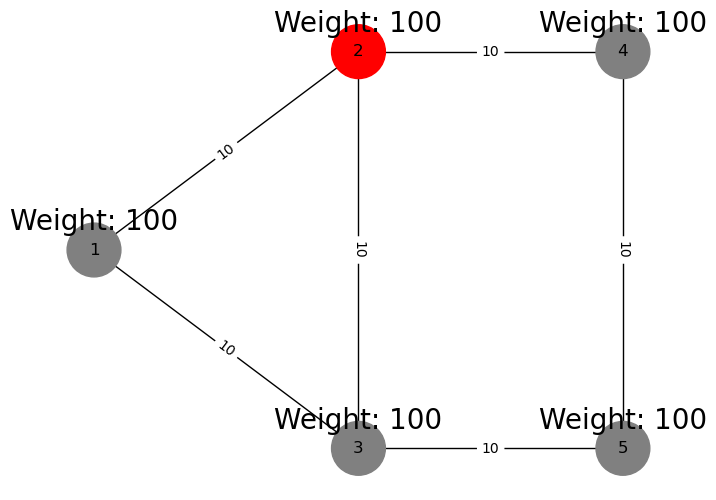

Got reward: -2.0


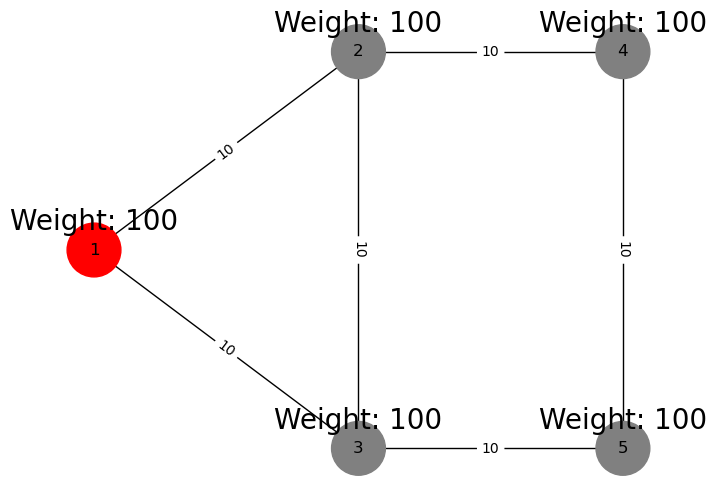

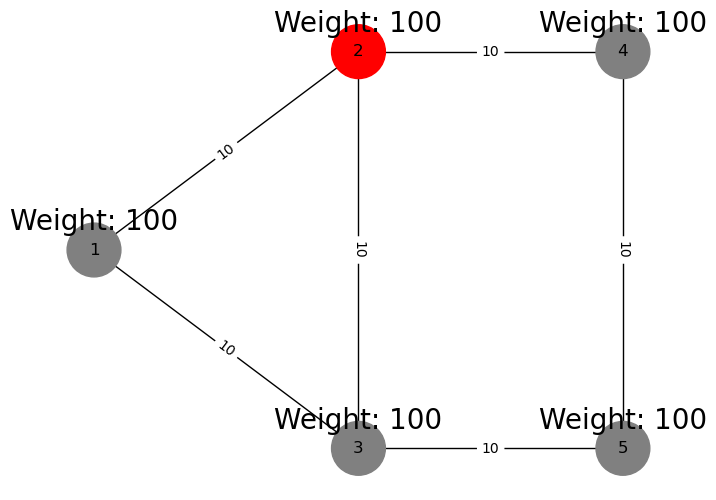

Got reward: -2.0


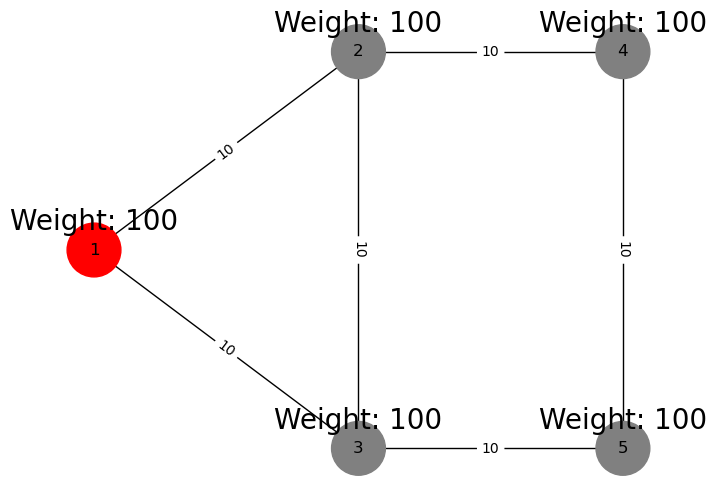

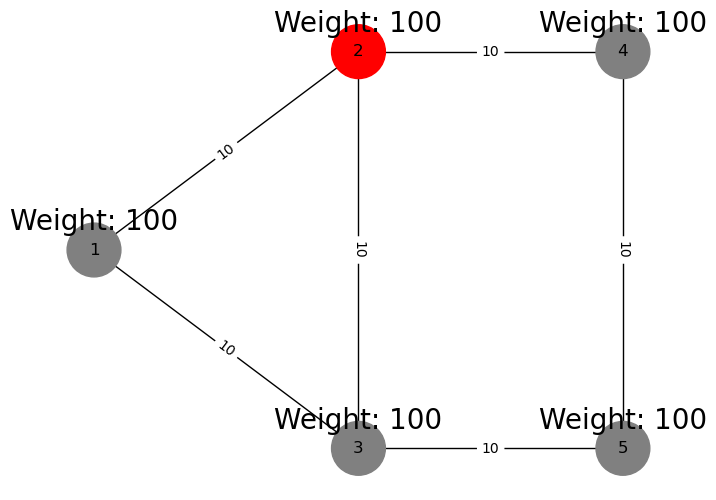

Got reward: -2.0


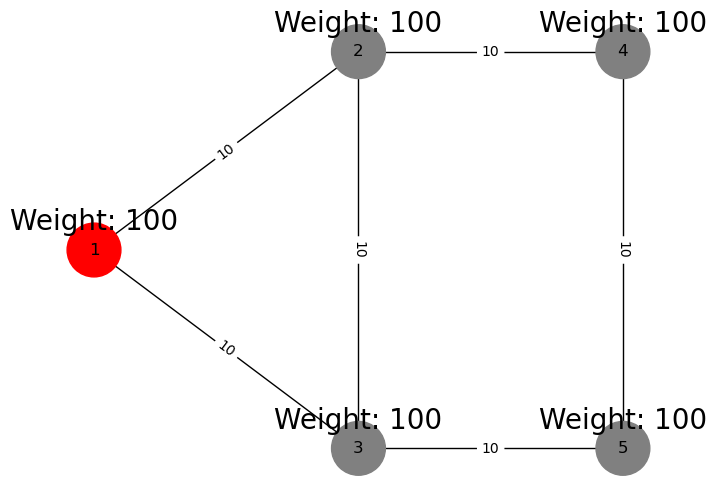

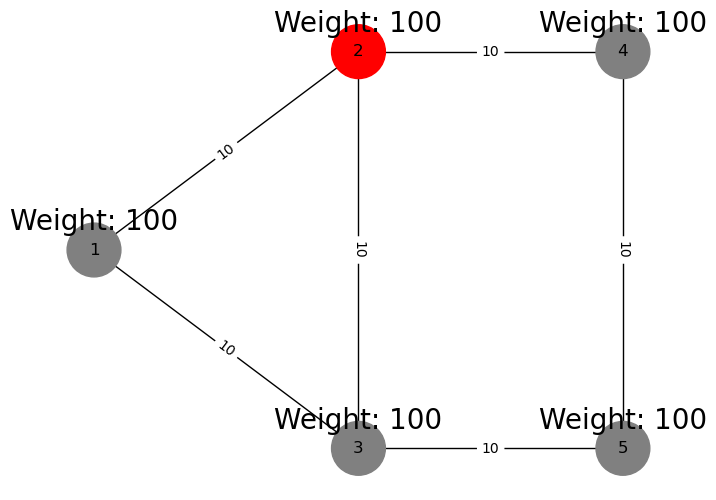

Got reward: -2.0


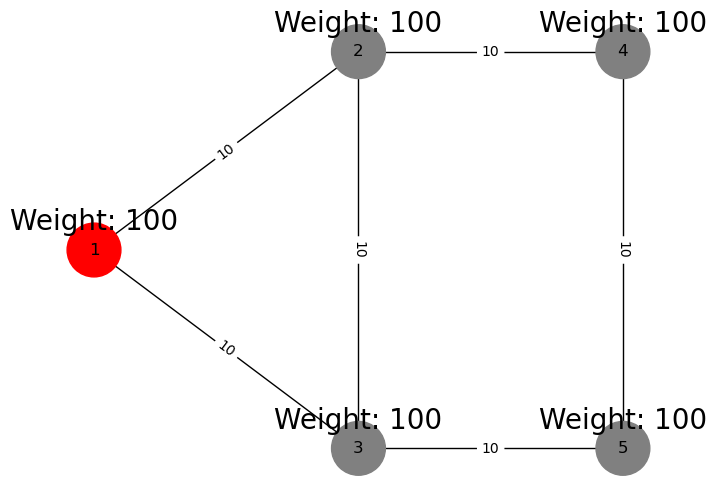

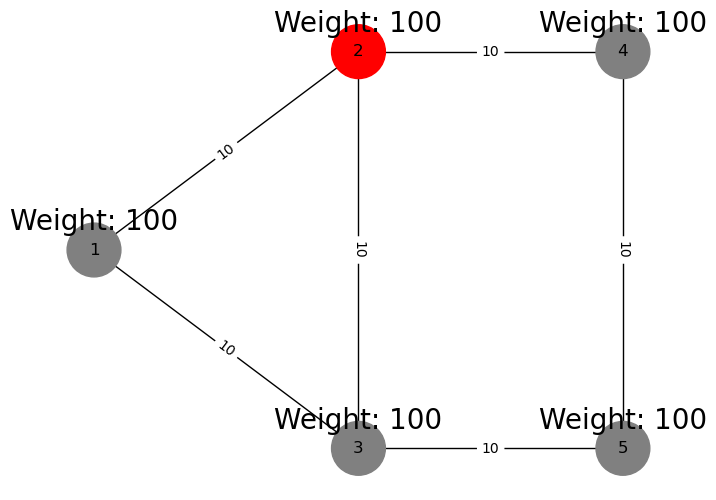

Got reward: -2.0


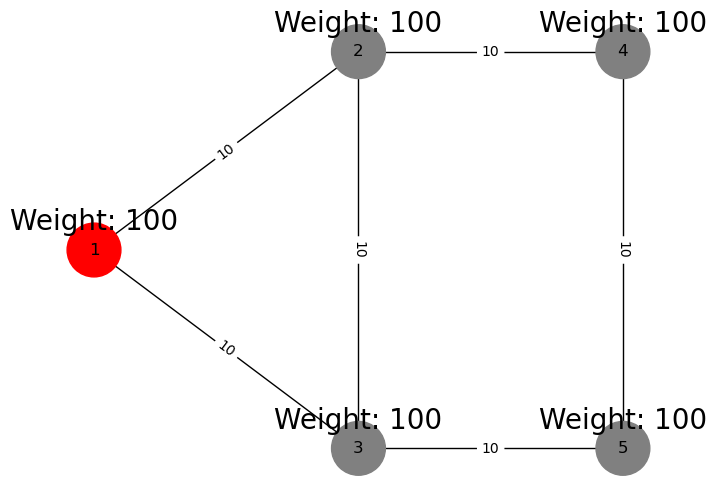

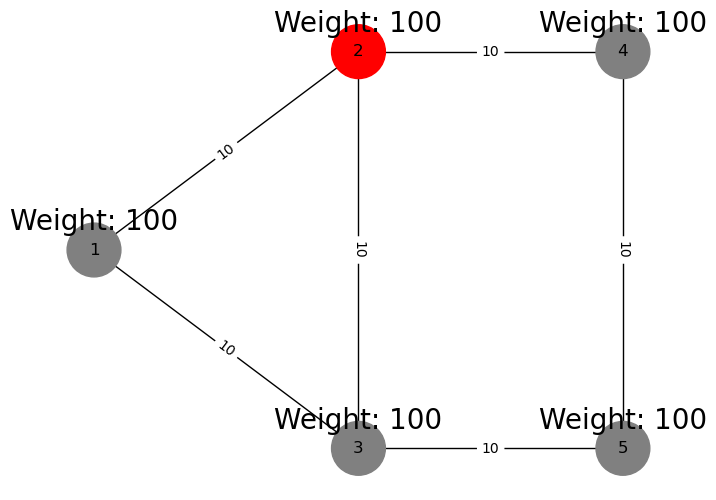

Got reward: -2.0


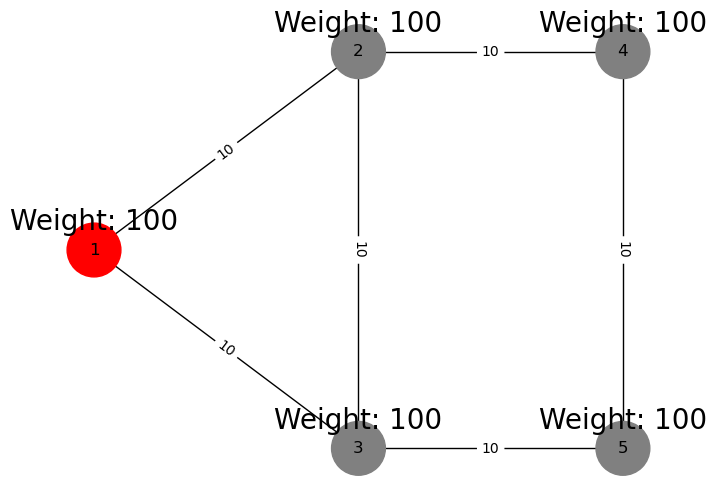

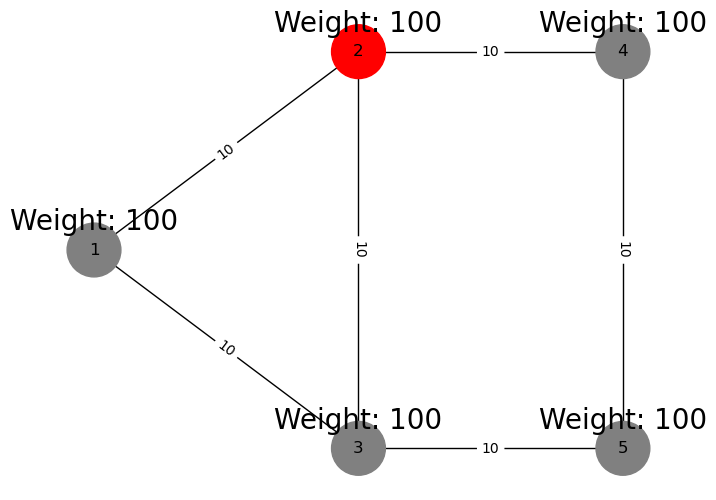

KeyboardInterrupt: 

In [115]:
# show terminal stationary action
for i in range(1000):
    G = 0
    done = False
    reward = 0
    state = env.reset()
    env.render()
    time.sleep(0.5)
    while not done:
        qvalues = agent.get_qvalues([state])
        action = qvalues.argmax(axis=-1)[0]
        state, r, done, _ = env.step(action)
        reward += r
        if done:
            print('Got reward: {}'.format(reward))
            break
        env.render()
        time.sleep(0.5)

        # print('Episode: {}\nV:\n {}\n'.format(i, agent.V))

        # state = next_state

In [24]:
#TODO

# Try to run this on another environment of your choice from OpenAI Gym
# read the accompanying text and try to enahnce the network using various variants


### Summary

In this notebook we saw how to train a DQN agent with experience replay and target networks. We can improve this agent with many tricks. As we go along, we will be implementing many of these variants.